# CA4 - Kongsberg satellite services

In [ ]:
import pandas as pd
import seaborn as sns 
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import make_scorer, f1_score
from sklearn.model_selection import cross_val_score, ParameterGrid
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


## 1. Reading and cleaning data
First we read in the data and clean out the NaN values using pandas. Then we remap the categorical variable (which is the one we want to predict) to numerical values by a simple dictionary remap.
Then we make a pairplot with 2000 random samples (to keep the computing time down) to visualise the data.

In [ ]:
# Load data from csv files
traindata = pd.read_csv("data/train.csv") 
testdata = pd.read_csv("data/test.csv") 

# Confirm that there are no remaining missing values
missing_values = traindata.isnull().sum()
print(missing_values)
print(traindata.shape)

obj_ID           0
alpha            0
delta            0
u              362
g                0
r                0
i                0
z                0
run_ID           0
rerun_ID         0
cam_col          0
field_ID         0
spec_obj_ID      0
class            0
redshift         0
plate            0
MJD              0
fiber_ID         0
dtype: int64
(80000, 18)


In [ ]:
# Clean the data by removing rows with missing values
traindata = traindata.dropna(axis=0)
missing_values = traindata.isnull().sum()
print(missing_values)
print(traindata.shape)

obj_ID         0
alpha          0
delta          0
u              0
g              0
r              0
i              0
z              0
run_ID         0
rerun_ID       0
cam_col        0
field_ID       0
spec_obj_ID    0
class          0
redshift       0
plate          0
MJD            0
fiber_ID       0
dtype: int64
(79638, 18)


In [ ]:
#Make dictionary that maps each class name to a number
size_mapping = {'GALAXY': 0, 'QSO': 1, 'STAR': 2}

#Making sure not to ruin everything if this cell is ran twice by accident. This turns the numbers into NaN
if traindata['class'].dtype == 'object' or isinstance(traindata['class'].dtype, pd.StringDtype):
    traindata['class'] = traindata['class'].map(size_mapping)

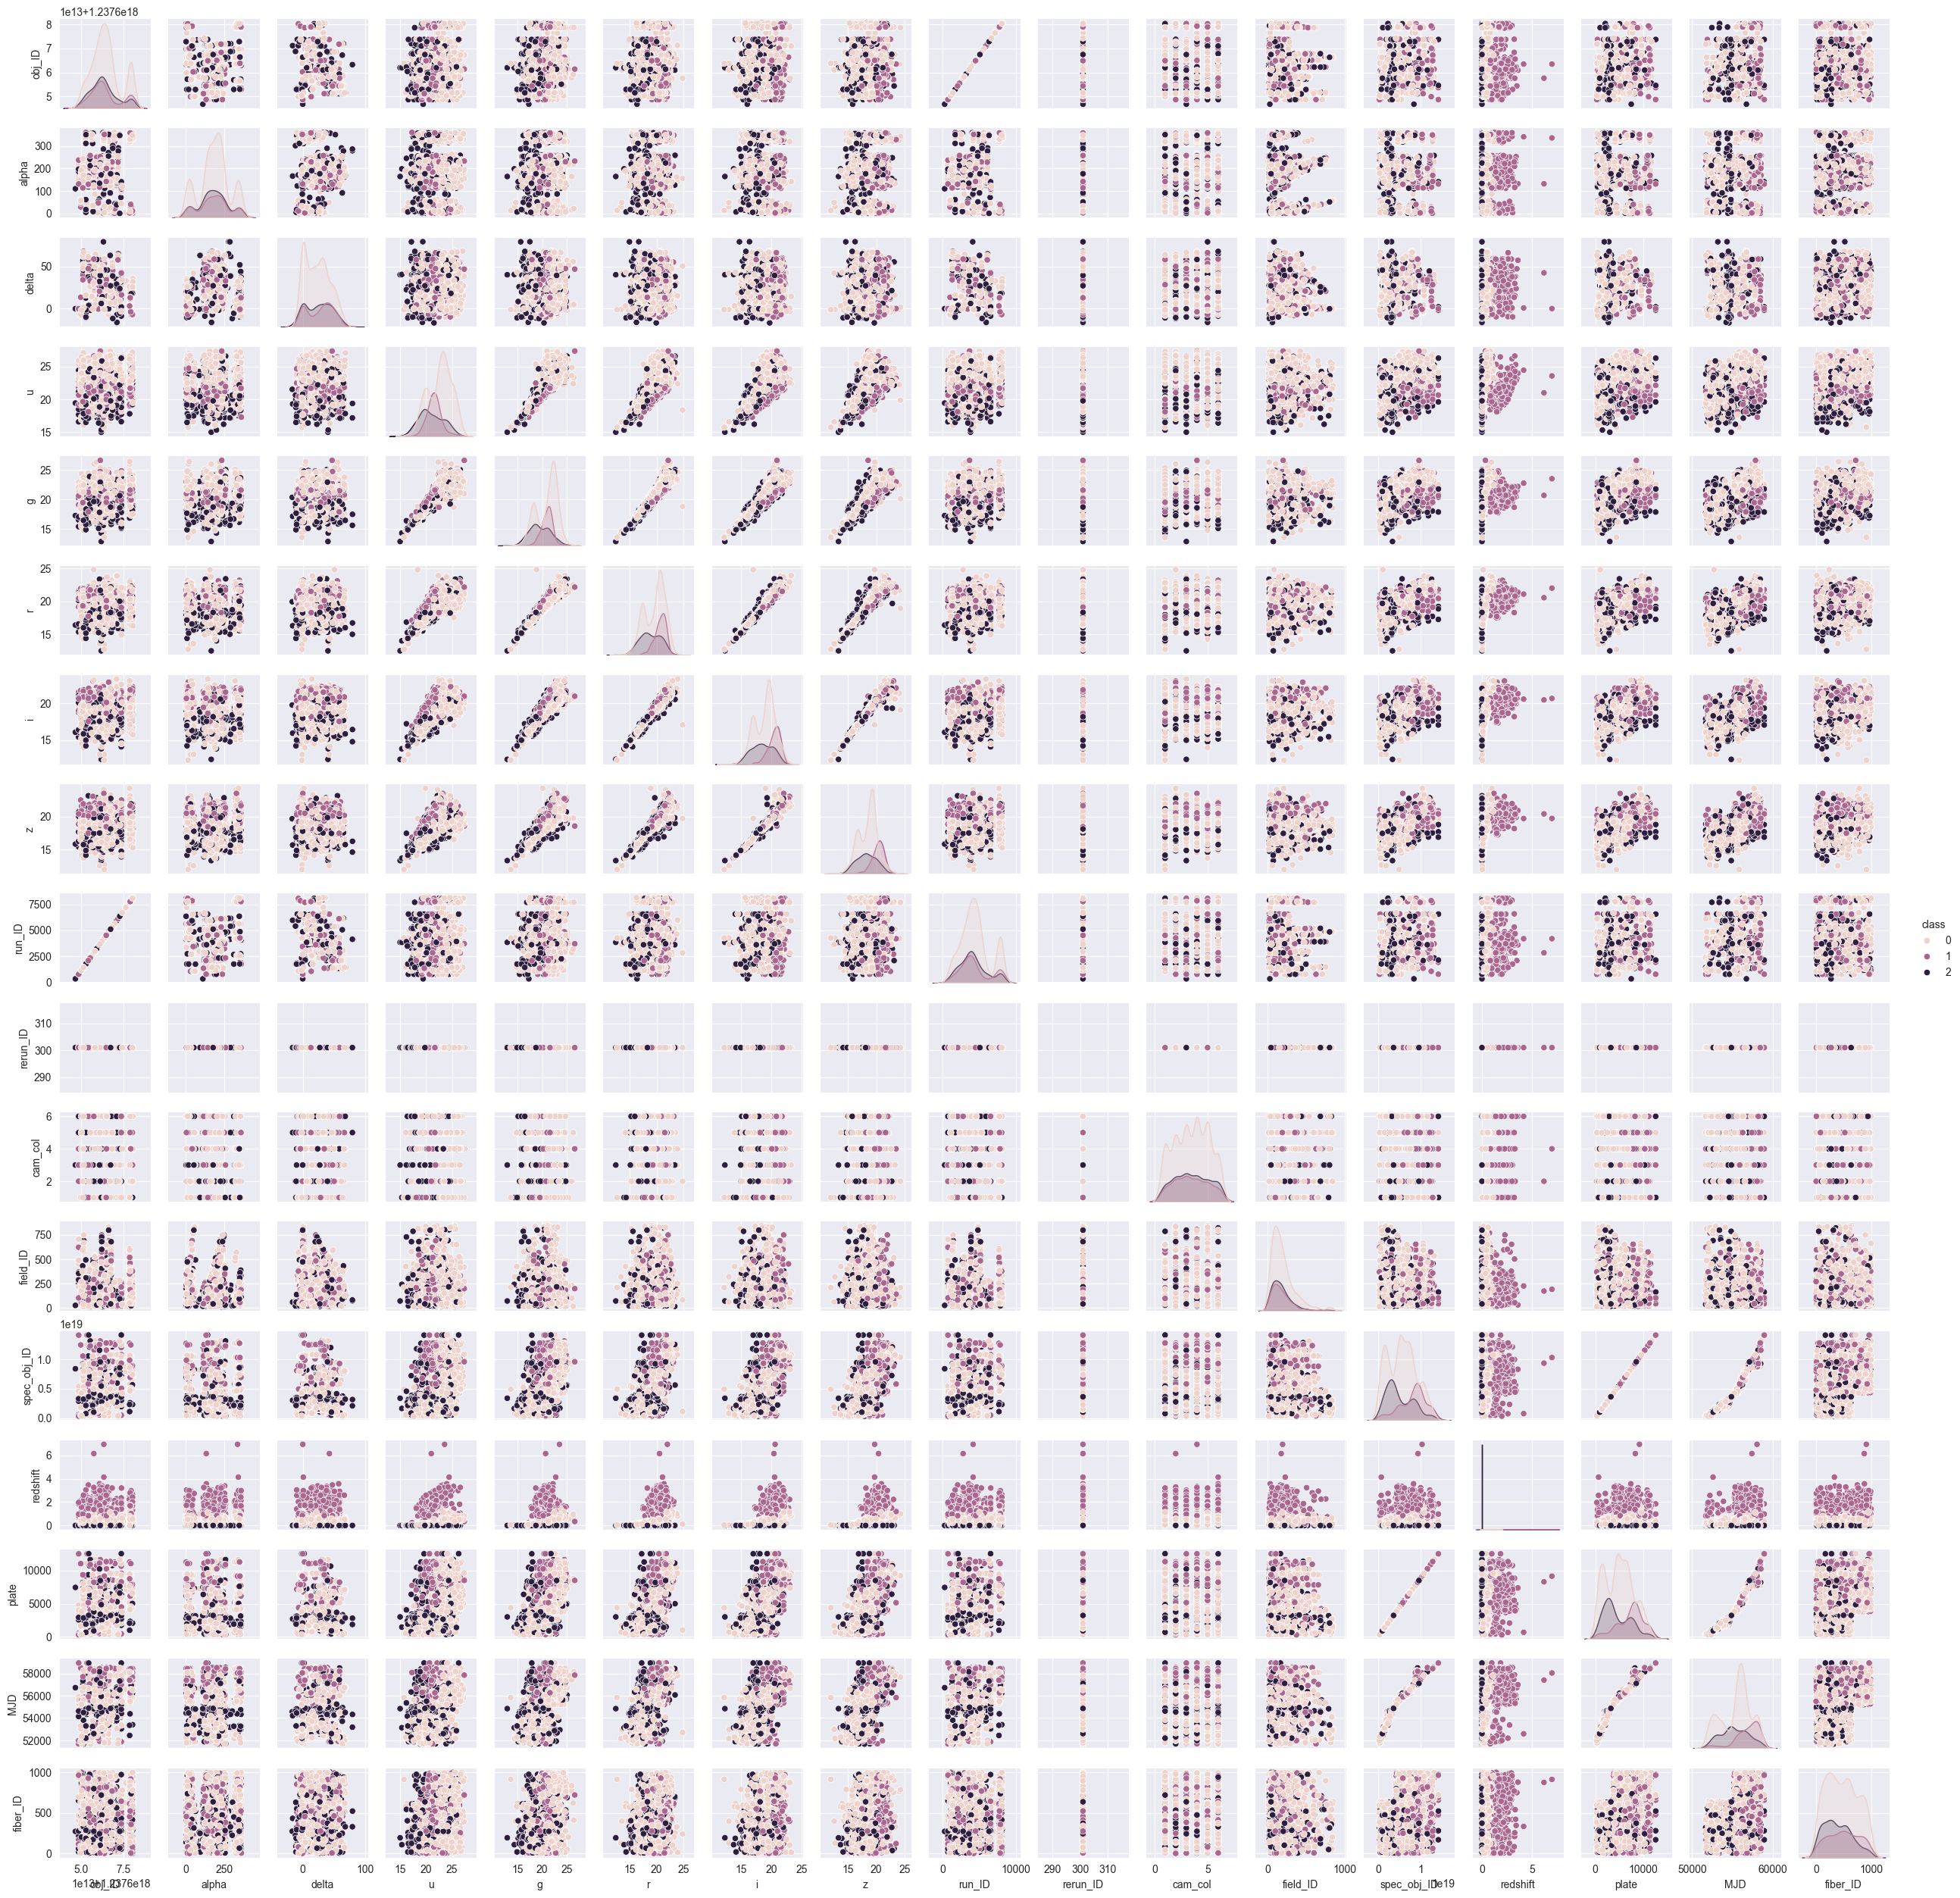

In [ ]:
#Random sample of 2000 rows from the training data for visualization
sample_df = traindata.sample(n=2000, random_state=42)
sns.pairplot(sample_df, hue="class", height=1.5)

It is quite hard to interpret such a large pairplot, but one can get an intuition of which features actually contribute and which ones just create more noise. Since we will be applying PCA later, no features are removed here yet.

<Axes: >

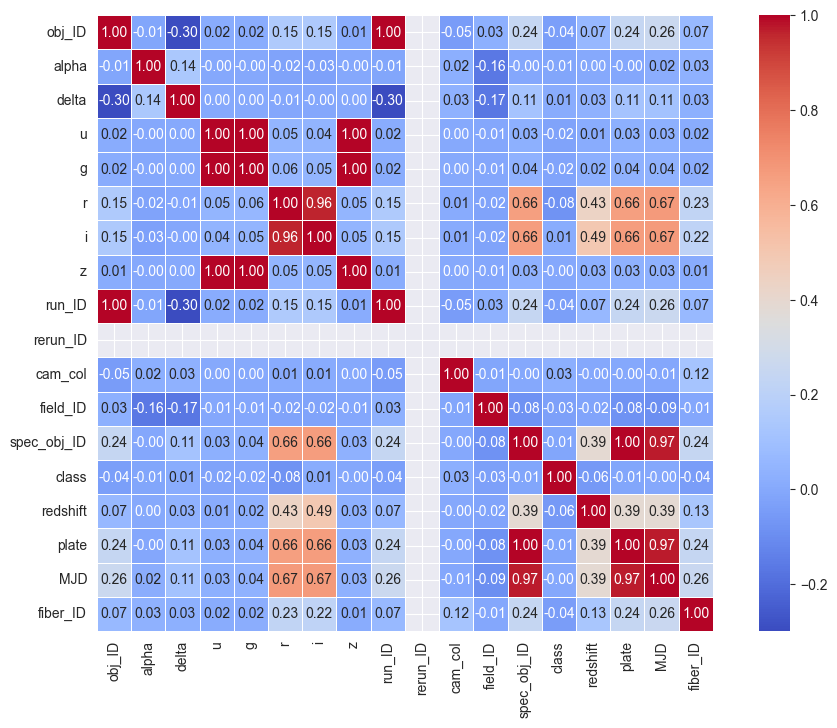

In [ ]:
# Calculate the correlation matrix to see how features are related to each other
corr_matrix = traindata.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True, linewidths=0.5)

## 2. Randomforest!
After some trial and error, and some playing around, we discovered that just a plain old randomforest model with no scaling or PCA or any other "fancy" methods performed better than all the other models. Therefore, before we go further into scaling and PCA and other pipelines, we want to provide the code for best performing model.
This is also the model that has been uploaded to Kaggle with an F1-score of 0.976.


In [ ]:
# Separate the input features for training
X = traindata.drop(columns=["class"], axis=0)
y = traindata["class"]

In [ ]:
# These features are what come as standard when creating a random forest classifier object, they are not manually defined in the example below
#max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200,random_state=42

#Train a random forest model using cross-validation
randomforest = RandomForestClassifier(random_state=42)

f1 = make_scorer(f1_score, average='macro')
scores = cross_val_score(randomforest, X, y, cv=5, scoring=f1)

# Print F1 scores from each fold and the average score for overall performance
print(f'F1 scores for each fold: {scores}')
print(f'Average F1 score: {scores.mean():.3f}')

KeyboardInterrupt: 

## 3. More preprocessing
Since the randomforest module perfomed the best on the unscaled and non preprocessed data, we did this before moving on to more preprocessing as removing outliers and creating a boxplot


In [26]:
# Compute IQR
Q1 = X.quantile(0.25)
Q3 = X.quantile(0.75)
IQR = Q3 - Q1

# Boolean mask: keep rows where all values are within [Q1 - 2*IQR, Q3 + 2*IQR]
mask = ~((X < (Q1 - 2.5 * IQR)) | (X > (Q3 + 2.5 * IQR))).any(axis=1)

# Apply mask
X = X[mask]
y = y[mask]

# Feedback
print(f"Removed {(~mask).sum()} outliers using 2.5 * IQR")

Removed 4881 outliers using 2.5 * IQR


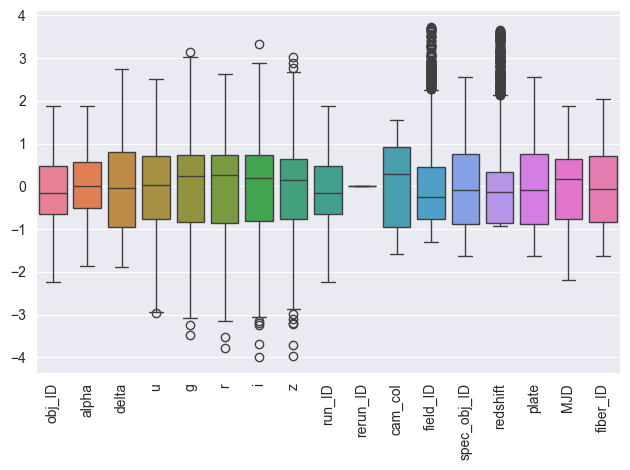

In [ ]:
# Take a sample of 3000 feature rows for visualization
sample_df = X.sample(3000, random_state=42)

# Standardize the feature
scaler = StandardScaler()
scaled_df = pd.DataFrame(scaler.fit_transform(sample_df), columns=sample_df.columns)

#Plotting a boxplot
sns.boxplot(data=scaled_df)
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

## 4. Pipeline 1 - kernel pipeline
First we see how many PCA components we need to keep most of the explained variance using the least amount of components. The code here is fetched from the 05_PCA_iris_data.ipynb file on canvas and chanced accordingly to be used on our dataset.
Then a pipeline is defined with the amount of components from the cell above, and by using hyperparameter optimization we find the best values for C and gamma since we use the RBF kernel. We use TQDM to get an estimate of how long a gridsearch will take.
Finally we define the final pipeline with optimized parameters and test it on the data to get the F1 accuracy score. 

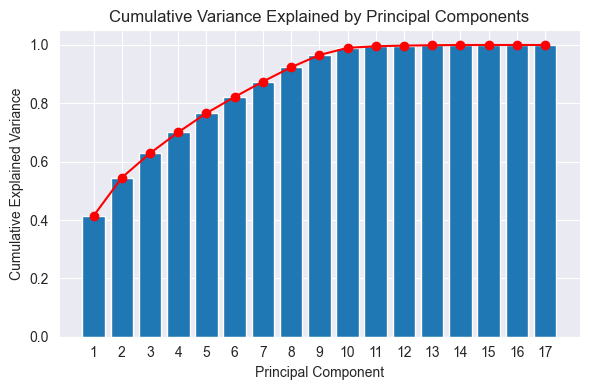

In [ ]:
# Standardize the feature
X_scaled = StandardScaler().fit_transform(X)

# Initialize PCA
n_components_pca = PCA()
X_train_PCA = n_components_pca.fit_transform(X_scaled)

# Get cumulative variance explained and count how many components
cum_var = n_components_pca.explained_variance_ratio_.cumsum()
num_components = len(cum_var)

# Plot cumulative variance explained
plt.figure(figsize=(6, 4))
plt.bar(range(1, num_components + 1), cum_var)
plt.plot(range(1, num_components + 1), cum_var, marker='o', color='red')
plt.title('Cumulative Variance Explained by Principal Components')
plt.xlabel('Principal Component')
plt.ylabel('Cumulative Explained Variance')
plt.xticks(range(1, num_components + 1))
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# Defining pipeline with PCA (10 components), and an SVC classifier
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=10)),
    ('classifier', SVC())
])

# Define hyperparamenter grid manually to tune SVC
param_grid = {
    'classifier__C': [0.1, 1, 10],
    'classifier__kernel': ['rbf'],
    'classifier__gamma': [0.001, 0.01, 0.1, 1]
}

# Sets up F1 scoring with macro averaging for balanced class evaluation
f1 = make_scorer(f1_score, average='macro')

# Store results in a list
results = []

# Iterate with progress bar
for params in tqdm(ParameterGrid(param_grid), desc="Grid Search Progress"):
    pipeline.set_params(**params)
    scores = cross_val_score(pipeline, X, y, cv=2, scoring=f1, n_jobs=-1)
    results.append((params, scores.mean()))

# Find best parameters and score
best_params, best_score = max(results, key=lambda x: x[1])

# Printing the result
print("Best parameters:", best_params)
print(f"Best F1 score: {best_score:.3f}")

Grid Search Progress: 100%|██████████| 12/12 [22:48<00:00, 114.05s/it]


Best parameters: {'classifier__C': 10, 'classifier__gamma': 0.01, 'classifier__kernel': 'rbf'}
Best F1 score: 0.951


In [ ]:
# Defining pipeline with PCA (10 components), and an SVC classifier
pipeline_svm = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=10)),
    ('classifier', SVC(C=10, gamma=0.01))
])

# Defining F1 scorer
f1 = make_scorer(f1_score, average='weighted')

# Running cross-validation with F1 scoring on the pipeline
scores = cross_val_score(pipeline_svm, X, y, cv=5, scoring=f1)

# Print results
print(f'F1 scores for each fold: {scores}')
print(f'Average F1 score: {scores.mean():.3f}')

F1 scores for each fold: [0.96294195 0.96294676 0.96111538 0.96354633 0.96428004]
Average F1 score: 0.963


## 5. Pipeline 2 - regularization pipeline
For our regression pipeline, we again apply the same PCA as before with the same components and use the L2-regularization parameter to avoid overfitting. For the hyperparameter optimization we again use the parametergrid to find the best C and the amount of iterations. Then we score it using the F1 score as before.
Finally we use the optimized parameters and score it, with the accuracy being still being lower than the randomforest.

In [ ]:
# Defining pipeline with PCA and LogisticRegression, no max_iter and c
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=10)),
    ('classifier', LogisticRegression(penalty='l2', solver='lbfgs'))
])

# Defining hyperparamenter grid manually to tune LogisticRegression
param_grid = {
    'classifier__C': [1, 10, 20, 50],
    'classifier__max_iter': [200, 500, 1000]
}

# Making the avg-macro f1 scorer
f1 = make_scorer(f1_score, average='macro')

# Storing results
results = []

# Manual grid search with progress bar
for params in tqdm(ParameterGrid(param_grid), desc="Grid Search Progress"):
    pipeline.set_params(**params)
    scores = cross_val_score(pipeline, X, y, cv=5, scoring=f1, n_jobs=-1)
    results.append((params, scores.mean()))

# Find best parameters and score
best_params, best_score = max(results, key=lambda x: x[1])

# Printing the output
print("Best parameters:", best_params)
print(f"Best macro F1 score: {best_score:.3f}")

Grid Search Progress: 100%|██████████| 48/48 [01:04<00:00,  1.34s/it]


Best parameters: {'classifier__C': 50, 'classifier__max_iter': 200, 'pca__n_components': 15}
Best macro F1 score: 0.948


In [ ]:
# Defining pipeline with PCA and LogisticRegression (max_iter=200 and c=50)
pipeline_LR = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=15)),
    ('classifier', LogisticRegression(penalty='l2', solver='lbfgs', max_iter=200, C=50))
])

# Define F1 scorer
f1 = make_scorer(f1_score, average='weighted')

# Run cross-validation with F1 scoring on the pipeline
scores = cross_val_score(pipeline_LR, X, y, cv=5, scoring=f1)

# Print results
print(f'F1 scores for each fold: {scores}')
print(f'Average F1 score: {scores.mean():.3f}')

F1 scores for each fold: [0.96059061 0.95977511 0.96158307 0.9611831  0.96032397]
Average F1 score: 0.961


## 6. Confusion matrix
The confusion matrix is applied to the best model so far, being the uncleaned data being passed into the standard randomforest model. 
It says where the model predicts wrong, and can give an intuition of where we can focus time and energy for the model to improve. 
Also the named labels are applied for easier understanding. 

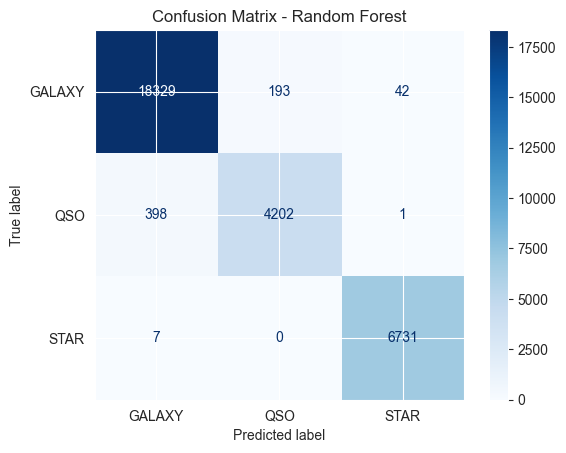

In [ ]:
#Inverse mapping: from number to class name
label_mapping = {0: 'GALAXY', 1: 'QSO', 2: 'STAR'}

#Splitting the data ( 40% test, 60% train)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.4, random_state=42, stratify=y
)

#Train the Random Forest
randomforest = RandomForestClassifier(random_state=42)
randomforest.fit(X_train, y_train)

#Predict on the test set
y_pred = randomforest.predict(X_test)

#Creating and plot the confusion matrix
cm = confusion_matrix(y_test, y_pred)
display_labels = [label_mapping[i] for i in sorted(label_mapping)]

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=display_labels)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix - Random Forest")
plt.show()

## 7. Kaggle submission
This is the code used for the best performed kaggle submission

In [ ]:
#Training a randomforest classifier
randomforest_submission = RandomForestClassifier(max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200,random_state=42)
randomforest_submission.fit(X, y)

test_predictions = randomforest_submission.predict(testdata)

# Create a DataFrame with ID and predicted class
submission_df = pd.DataFrame({
    "ID": range(len(test_predictions)),
    "class": test_predictions
})

# Preview the first few rows
print(submission_df.head())

#Save predictions to CSV for submission
submission_df.to_csv("submission1.csv", index=False)

   ID  class
0   0      0
1   1      2
2   2      2
3   3      2
4   4      2


## 8. Conclusion
It seems like, that for this particular dataset, that less is more.
Meaning the use of just the base random forest classifier outperforms more complicated pipelines and data cleaning.
When applying data cleaning, PCA, regularization or a kernel, the final result uploaded to kaggle always seemed to be worse than the standard, uncleaned random forest module. Nevertheless, it is important to understand what all the components do and to try them out to improve the result.